# Initial Data Exploration

Load all the raw data

In [14]:
import os
import pandas as pd

def load_all_data():
    home = os.path.expanduser("~")
    base_dir = os.path.join(
        home,
        "Documents",
        "data analytics",
        "Data-Analytics-and-Learning-Methods",
        "data",
        "raw",
    )

    activities = ["running", "sit_down", "stairs", "stand_up", "walking"]

    data = {}

    for activity in activities:
        activity_dir = os.path.join(base_dir, activity)

        subfolders = [
            os.path.join(activity_dir, d)
            for d in os.listdir(activity_dir)
            if os.path.isdir(os.path.join(activity_dir, d))
        ]

        data[activity] = {}

        for folder in subfolders:
            folder_name = os.path.basename(folder)
            csvs = {}
            for file_name in os.listdir(folder):
                if file_name.endswith(".csv"):
                    file_path = os.path.join(folder, file_name)
                    print(f"Loading {file_path}...")
                    try:
                        df = pd.read_csv(file_path, skipinitialspace=True)
                        if df.empty:
                            continue
                        df.columns = df.columns.str.strip()
                        csvs[file_name] = df
                    except Exception as e:
                        print(f"Could not load {file_name}: {e}")
            if csvs:
                data[activity][folder_name] = csvs

    return data

# Load all data into memory
all_data = load_all_data()
print("Data loaded. Available activities:", list(all_data.keys()))


Loading C:\Users\ozdep\Documents\data analytics\Data-Analytics-and-Learning-Methods\data\raw\running\Berkan_Run_1-2025-09-14_14-12-58\Accelerometer.csv...
Loading C:\Users\ozdep\Documents\data analytics\Data-Analytics-and-Learning-Methods\data\raw\running\Berkan_Run_1-2025-09-14_14-12-58\AccelerometerUncalibrated.csv...
Loading C:\Users\ozdep\Documents\data analytics\Data-Analytics-and-Learning-Methods\data\raw\running\Berkan_Run_1-2025-09-14_14-12-58\Annotation.csv...
Could not load Annotation.csv: No columns to parse from file
Loading C:\Users\ozdep\Documents\data analytics\Data-Analytics-and-Learning-Methods\data\raw\running\Berkan_Run_1-2025-09-14_14-12-58\Gravity.csv...
Loading C:\Users\ozdep\Documents\data analytics\Data-Analytics-and-Learning-Methods\data\raw\running\Berkan_Run_1-2025-09-14_14-12-58\Gyroscope.csv...
Loading C:\Users\ozdep\Documents\data analytics\Data-Analytics-and-Learning-Methods\data\raw\running\Berkan_Run_1-2025-09-14_14-12-58\GyroscopeUncalibrated.csv...
Lo

To analyze the data plot the .csv files of one random raw data from each class, to see where the data needs to be cleaned up

The next step is to clean the data. Since the data was recorded by placing our phones on an arm band, the part where we were placing the phone in the arm band needs to be removed as it is not recording any of the class activities. By looking at the plots we can see that this part is clearly visible through:

- Constant unfluctuating values for Accelerometer.csv/AccelerometerUncalibrated.csv/Gyroscope.csv file for the running class
- Constant unfluctuating values for Accelerometer.csv/AccelerometerUncalibrated.csv/Gyroscope.csv file for the walking class
- Value of 0 for Accelerometer.csv for sitting down
- Values that are in a constant fluctuation for Accelerometer.csv for stairs
- No change needed for standing up

Activity: running | Folder: Berkan_Run_1-2025-09-14_14-12-58


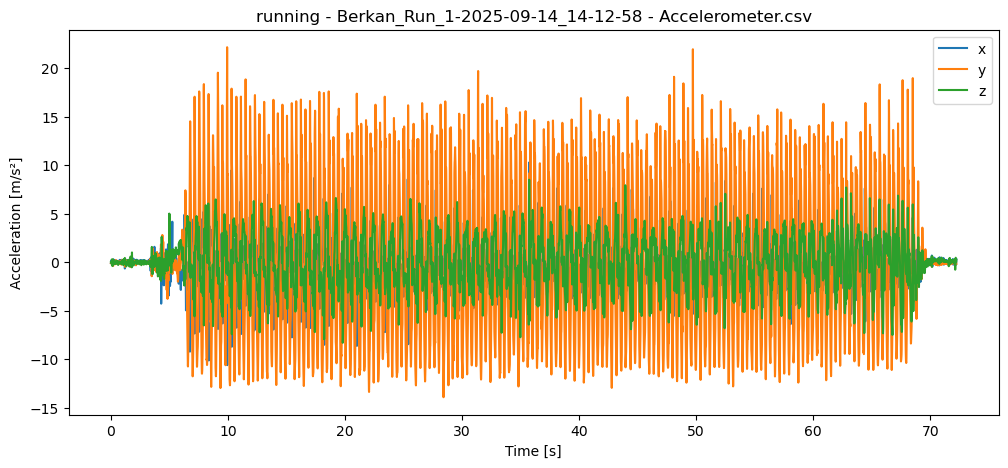

In [45]:
import matplotlib.pyplot as plt
import random

# 🔹 Pick one folder from running and plot Accelerometer.csv
for activity, folders in all_data.items():
    if not folders:
        continue
    if activity == "running":

        #chosen_folder = random.choice(list(folders.keys()))

        # chose the first folder for reproducibility
        chosen_folder = list(folders.keys())[0]
        print(f"Activity: {activity} | Folder: {chosen_folder}")

        df = folders[chosen_folder]["Accelerometer.csv"]

        # Plot accelerometer signals
        time = df["seconds_elapsed"].values
        plt.figure(figsize=(12,5))
        plt.plot(time, df["x"], label="x")
        plt.plot(time, df["y"], label="y")
        plt.plot(time, df["z"], label="z")

        plt.title(f"{activity} - {chosen_folder} - Accelerometer.csv")
        plt.xlabel("Time [s]")
        plt.ylabel("Acceleration [m/s²]")
        plt.legend()
        plt.show()
        break


In order to trim the data automatically and correctly, for the running class the following algorithm was deployed:

- Access the min and max values of the y value in the Accelerometer.csv file

- Outline a 5 seconds time frame

- For every time frame check whether the min/max values are greater than twice the amount of the current time frame's min/max values 

- If it is then mark the exact time frame on the original graph

Activity: running | Folder: Berkan_Run_1-2025-09-14_14-12-58


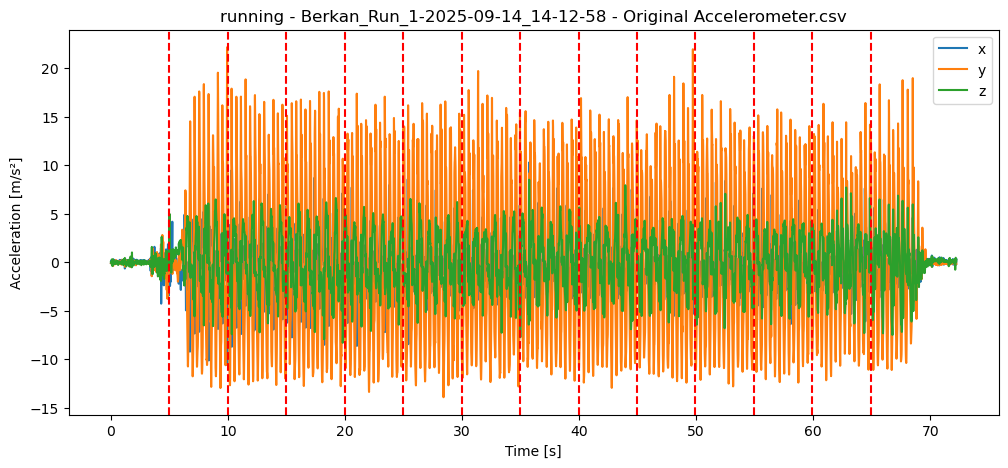

In [44]:
import matplotlib.pyplot as plt
import random
import numpy as np

def get_y_axis_limits(df):
    return df["y"].min(), df["y"].max()


# Access the Accelerometer.csv data of the running activity
for activity, folders in all_data.items():
    if not folders:
        continue
    if activity == "running":
        #chosen_folder = random.choice(list(folders.keys()))

        chosen_folder = list(folders.keys())[0]
        print(f"Activity: {activity} | Folder: {chosen_folder}")

        df = folders[chosen_folder]["Accelerometer.csv"]

        time = df["seconds_elapsed"].values
        y_values = df["y"].values

        # Parameters
        window_size = 5  # seconds
        sample_rate = len(time) / (time[-1] - time[0])  # approx samples per second
        step = int(window_size * sample_rate)

        cutoff_times = []
        prev_y_min, prev_y_max = None, None

        # Slide through the signal in windows
        for start in range(0, len(y_values), step):
            end = min(start + step, len(y_values))
            window_y = y_values[start:end]

            if len(window_y) == 0:
                continue

            curr_y_min, curr_y_max = window_y.min(), window_y.max()

            if prev_y_min is not None and prev_y_max is not None:
                # Check sudden jump relative to previous window
                if (curr_y_max > 2 * prev_y_max) or (curr_y_min < 0.5 * prev_y_min):
                    cutoff_times.append(time[start])  # mark cutoff at window start

            prev_y_min, prev_y_max = curr_y_min, curr_y_max

        
        plt.figure(figsize=(12,5))
        plt.plot(time, df["x"], label="x")
        plt.plot(time, df["y"], label="y")
        plt.plot(time, df["z"], label="z")

        # Mark cutoff points
        for ct in cutoff_times:
            plt.axvline(ct, color="red", linestyle="--")

        plt.title(f"{activity} - {chosen_folder} - Original Accelerometer.csv")
        plt.xlabel("Time [s]")
        plt.ylabel("Acceleration [m/s²]")
        plt.legend()
        plt.show()
        break


# Data Augmentation

To increase the size of the dataset we will be making the windows (time frames) overlap by 50% so half of the samples in a window are also part of the next window. 

Activity: running | Folder: Berkan_Run_1-2025-09-14_14-12-58


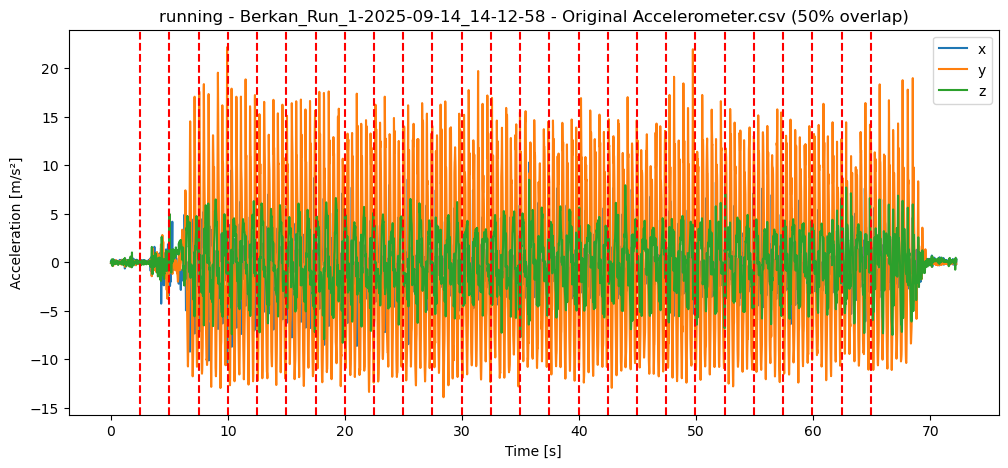

In [50]:
import matplotlib.pyplot as plt
import random
import numpy as np

def get_y_axis_limits(df):
    return df["y"].min(), df["y"].max()


# Access the Accelerometer.csv data of the running activity
for activity, folders in all_data.items():
    if not folders:
        continue
    if activity == "running":
        chosen_folder = list(folders.keys())[0]  # pick first folder
        print(f"Activity: {activity} | Folder: {chosen_folder}")

        df = folders[chosen_folder]["Accelerometer.csv"]

        time = df["seconds_elapsed"].values
        y_values = df["y"].values

        # Parameters
        window_size = 5  # seconds
        sample_rate = len(time) / (time[-1] - time[0])  # approx samples per second
        step = int(window_size * sample_rate)
        stride = step // 2   # 50% overlap

        cutoff_times = []
        prev_y_min, prev_y_max = None, None

        # Slide through the signal with 50% overlap
        for start in range(0, len(y_values) - step + 1, stride):
            end = start + step
            window_y = y_values[start:end]

            if len(window_y) == 0:
                continue

            curr_y_min, curr_y_max = window_y.min(), window_y.max()

            if prev_y_min is not None and prev_y_max is not None:
                # Check sudden jump relative to previous window
                if (curr_y_max > 2 * prev_y_max) or (curr_y_min < 0.5 * prev_y_min):
                    cutoff_times.append(time[start])  # mark cutoff at window start

            prev_y_min, prev_y_max = curr_y_min, curr_y_max

        
        plt.figure(figsize=(12,5))
        plt.plot(time, df["x"], label="x")
        plt.plot(time, df["y"], label="y")
        plt.plot(time, df["z"], label="z")

        # Mark cutoff points
        for ct in cutoff_times:
            plt.axvline(ct, color="red", linestyle="--")

        plt.title(f"{activity} - {chosen_folder} - Original Accelerometer.csv (50% overlap)")
        plt.xlabel("Time [s]")
        plt.ylabel("Acceleration [m/s²]")
        plt.legend()
        plt.show()
        break
